# MSDS 7337 - Natural Language Processing
## Homework 7
### Evangelos Giakoumakis

Library imports

In [113]:
from __future__ import print_function
import platform
import sys
import nltk
import requests
import re
from requests import get
from itertools import repeat
from bs4 import BeautifulSoup
import pandas as pd
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import ward, dendrogram

General system information

In [2]:
print (platform.platform())
print ("Python", sys.version)
print ("nltk", nltk.__version__)
print ("requests", requests.__version__)
print ("re", re.__version__)

Windows-10-10.0.17134
Python 2.7.15 |Anaconda, Inc.| (default, May  1 2018, 18:37:09) [MSC v.1500 64 bit (AMD64)]
nltk 3.3
requests 2.18.4
re 2.2.1


Function to parse the first 25 reviews given a movie link

In [3]:
def movie_review_crawler(url):
    response = get(url)
    html_soup = BeautifulSoup(response.text, 'html.parser')
    rev_containers = html_soup.find_all('div', class_ = 'text show-more__control')
    reviews = []
    for rv in rev_containers:
        reviews.append(rv.text)
    return reviews

Function to create a list of 100 reviews of science fiction movies 
Films used: (Matrix, Inception, Sunshine, Dragonball)

In [4]:
def my_review_crawler():
        matrix = movie_review_crawler("https://www.imdb.com/title/tt0133093/reviews?ref_=tt_urv")
        inception = movie_review_crawler("https://www.imdb.com/title/tt1375666/reviews?ref_=tt_urv")
        sunshine = movie_review_crawler("https://www.imdb.com/title/tt0448134/reviews?ref_=tt_urv")
        dragonball = movie_review_crawler("https://www.imdb.com/title/tt1098327/reviews?ref_=tt_urv")
        scifi_reviews = matrix + inception + sunshine + dragonball
        return scifi_reviews

Fetch and place all reviews on list called reviews

In [7]:
reviews = my_review_crawler()

Load NLTK's English stopwords as variable called 'stopwords'

In [9]:
stopwords = nltk.corpus.stopwords.words('english')

Load NLTK's SnowballStemmer as variabled 'stemmer'

In [10]:
stemmer = SnowballStemmer("english")

Function to tokenize callected reviews

In [11]:
def tokenize_clean(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if token not in stopwords and re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [13]:
totalvocab_tokenized = []
for i in reviews:
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
    
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized})
print ("there are %d items in vocab_frame" % vocab_frame.shape[0]) 

there are 41114 items in vocab_frame


tf-idf document similarity  

In [16]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_only, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(reviews) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()

dist = 1 - cosine_similarity(tfidf_matrix)

(100, 72)


1. 1.	In Python, select any one of the clustering methods covered in this course. Run it over the collection of reviews, and show at least two different ways of clustering the reviews, e.g., changing k in k-Means clustering or changing where you “cut” in Agnes or Diana.  

## K-Means Clustering

In [165]:
num_clusters = 4

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Multidimensional Scaling

In [166]:
MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

Setup cluster details

In [167]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a'}

#set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 
                 1: 'Cluster 2', 
                 2: 'Cluster 3', 
                 3: 'Cluster 4'}

In [168]:
titles = list(repeat(0, len(reviews)))

for a in range(len(reviews)):
    titles[a] = reviews[a][:20]

In [169]:
titles[:10]

[u'The story of a reluc',
 u'Without a doubt one ',
 u'Writing a review of ',
 u'** May contain spoil',
 u'The Matrix...when I ',
 u'I remember taking a ',
 u'My review of the bes',
 u'The Wachowski brothe',
 u"It's been a while si",
 u'The Matrix is one of']

Visualize results

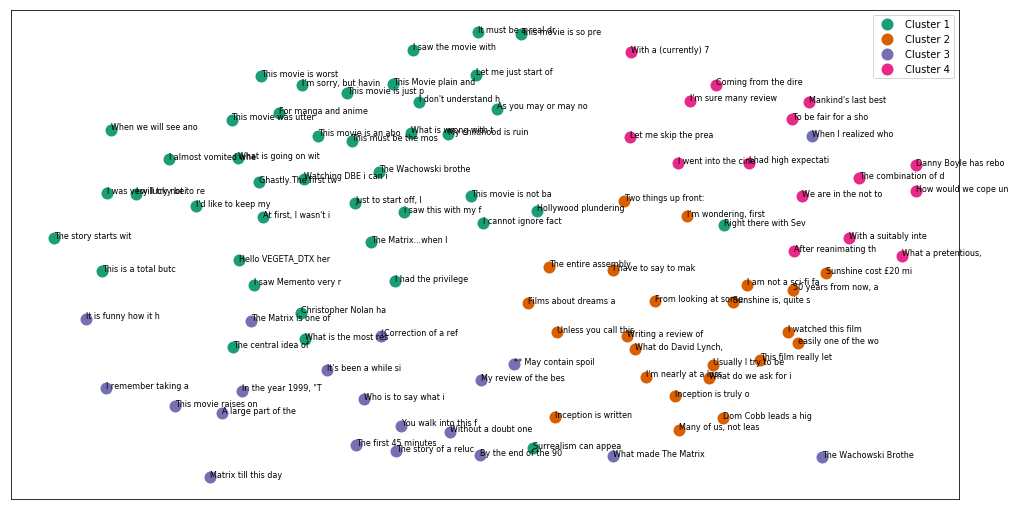

In [170]:
#some ipython magic to show the matplotlib plots inline
#%matplotlib inline

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles))

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc [i]['x'], df.loc [i]['y'], df.loc [i]['title'], size=8)  
    
plt.show() #show the plot

#plt.savefig('clusters.png')    

Function to get most prevalent words of text

In [171]:
def get_top_n_words(corpus, n=None):

    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

Create pandas data frame for easier manipulation

In [172]:
movies = { 'reviews': reviews, 'cluster': clusters }

frame = pd.DataFrame(movies, index = [clusters] , columns = ['reviews', 'cluster'])

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Find most common words of each cluster

In [173]:
common_words = get_top_n_words(frame['reviews'][0], 40)
common_words

[(u'the', 893),
 (u'and', 405),
 (u'to', 356),
 (u'of', 308),
 (u'is', 257),
 (u'it', 234),
 (u'movie', 205),
 (u'in', 189),
 (u'that', 180),
 (u'this', 180),
 (u'you', 123),
 (u'was', 118),
 (u'but', 104),
 (u'as', 100),
 (u'with', 99),
 (u'not', 96),
 (u'for', 95),
 (u'they', 79),
 (u'all', 78),
 (u'on', 73),
 (u'his', 69),
 (u'be', 63),
 (u'just', 62),
 (u'are', 61),
 (u'one', 59),
 (u'by', 58),
 (u'so', 57),
 (u'an', 57),
 (u'what', 57),
 (u'like', 56),
 (u'about', 56),
 (u'at', 55),
 (u'dragonball', 54),
 (u'or', 50),
 (u'if', 48),
 (u'have', 48),
 (u'even', 44),
 (u'only', 44),
 (u'out', 44),
 (u'who', 44)]

In [150]:
common_words = get_top_n_words(frame['reviews'][1], 40)
common_words

[(u'the', 920),
 (u'and', 409),
 (u'to', 376),
 (u'of', 315),
 (u'is', 269),
 (u'it', 237),
 (u'movie', 210),
 (u'in', 193),
 (u'that', 187),
 (u'this', 187),
 (u'you', 125),
 (u'was', 119),
 (u'but', 108),
 (u'with', 103),
 (u'as', 101),
 (u'not', 100),
 (u'for', 97),
 (u'they', 82),
 (u'on', 81),
 (u'all', 79),
 (u'his', 70),
 (u'be', 66),
 (u'are', 65),
 (u'just', 62),
 (u'one', 61),
 (u'so', 60),
 (u'what', 60),
 (u'by', 58),
 (u'an', 57),
 (u'like', 56),
 (u'about', 56),
 (u'at', 55),
 (u'dragonball', 54),
 (u'or', 51),
 (u'have', 50),
 (u'if', 48),
 (u'only', 48),
 (u'he', 47),
 (u'even', 46),
 (u'who', 45)]

In [174]:
common_words = get_top_n_words(frame['reviews'][2], 40)
common_words

[(u'the', 375),
 (u'and', 157),
 (u'of', 134),
 (u'is', 118),
 (u'in', 101),
 (u'to', 89),
 (u'that', 64),
 (u'it', 60),
 (u'matrix', 58),
 (u'this', 48),
 (u'film', 45),
 (u'for', 38),
 (u'with', 35),
 (u'you', 34),
 (u'was', 33),
 (u'one', 33),
 (u'movie', 30),
 (u'but', 30),
 (u'as', 30),
 (u'have', 29),
 (u'effects', 26),
 (u'he', 26),
 (u'his', 25),
 (u'what', 24),
 (u'by', 23),
 (u'not', 23),
 (u'reality', 22),
 (u'best', 22),
 (u'all', 21),
 (u'neo', 21),
 (u'on', 21),
 (u'world', 21),
 (u'my', 20),
 (u'we', 19),
 (u'action', 18),
 (u'movies', 18),
 (u'also', 18),
 (u'are', 18),
 (u'very', 18),
 (u'an', 18)]

In [152]:
common_words = get_top_n_words(frame['reviews'][3], 40)
common_words

[(u'the', 323),
 (u'and', 138),
 (u'of', 117),
 (u'is', 98),
 (u'in', 87),
 (u'to', 70),
 (u'that', 56),
 (u'matrix', 55),
 (u'it', 54),
 (u'this', 38),
 (u'film', 37),
 (u'for', 32),
 (u'one', 29),
 (u'you', 29),
 (u'movie', 28),
 (u'was', 28),
 (u'with', 28),
 (u'but', 26),
 (u'effects', 24),
 (u'his', 24),
 (u'as', 24),
 (u'have', 22),
 (u'he', 22),
 (u'all', 21),
 (u'what', 21),
 (u'best', 21),
 (u'my', 19),
 (u'we', 19),
 (u'reality', 19),
 (u'on', 19),
 (u'not', 19),
 (u'action', 18),
 (u'world', 18),
 (u'by', 18),
 (u'neo', 17),
 (u'are', 17),
 (u'also', 16),
 (u'an', 16),
 (u'movies', 15),
 (u'time', 15)]

2.	Try to write a short phrase to characterize (give a natural interpretation of) what each cluster is generally centered on semantically. Is this hard to do in some cases? If so, make note of that fact. 

Cluster 0: Sunshine movie reviews

Cluster 1: Dragonball movie reviews

Cluster 2: Inception movie reviews

Cluster 3: Matrix movie reviews

## Second Clustering methodology (K-Means)

In [153]:
num_clusters = 2

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [154]:
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [155]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02'}

#set up cluster names using a dict
cluster_names = {0: 'Cluster 1', 
                 1: 'Cluster 2'}

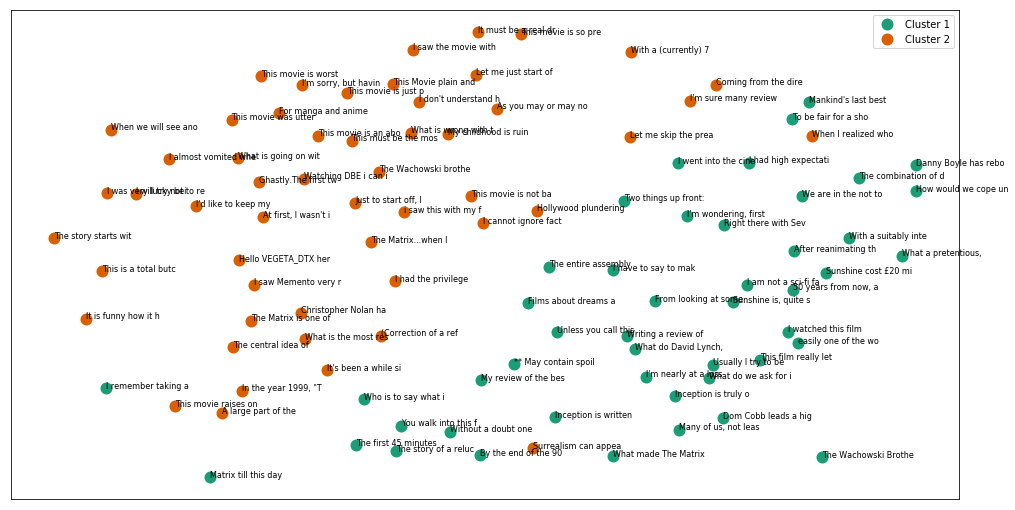

In [156]:
#some ipython magic to show the matplotlib plots inline
#%matplotlib inline

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles))

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc [i]['x'], df.loc [i]['y'], df.loc [i]['title'], size=8)  
    
plt.show() #show the plot

#plt.savefig('clusters.png')    

In [157]:
movies = { 'reviews': reviews, 'cluster': clusters }

frame = pd.DataFrame(movies, index = [clusters] , columns = ['reviews', 'cluster'])

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

In [158]:
common_words = get_top_n_words(frame['reviews'][0], 40)
common_words

[(u'the', 1502),
 (u'and', 651),
 (u'of', 596),
 (u'to', 567),
 (u'is', 463),
 (u'in', 382),
 (u'it', 365),
 (u'that', 337),
 (u'film', 298),
 (u'this', 210),
 (u'for', 187),
 (u'with', 173),
 (u'you', 168),
 (u'as', 158),
 (u'but', 145),
 (u'on', 144),
 (u'have', 133),
 (u'all', 129),
 (u'not', 125),
 (u'are', 124),
 (u'his', 121),
 (u'he', 113),
 (u'one', 112),
 (u'there', 101),
 (u'by', 100),
 (u'was', 99),
 (u'be', 95),
 (u'they', 92),
 (u'an', 89),
 (u'or', 88),
 (u'so', 86),
 (u'has', 85),
 (u'from', 84),
 (u'what', 82),
 (u'about', 81),
 (u'who', 76),
 (u'at', 72),
 (u'no', 72),
 (u'if', 68),
 (u'up', 68)]

In [159]:
common_words = get_top_n_words(frame['reviews'][1], 40)
common_words

[(u'the', 1145),
 (u'and', 483),
 (u'to', 436),
 (u'of', 398),
 (u'is', 330),
 (u'it', 272),
 (u'in', 250),
 (u'movie', 243),
 (u'this', 213),
 (u'that', 212),
 (u'was', 140),
 (u'you', 139),
 (u'but', 127),
 (u'with', 126),
 (u'for', 124),
 (u'as', 117),
 (u'not', 115),
 (u'on', 98),
 (u'all', 93),
 (u'they', 90),
 (u'are', 81),
 (u'one', 80),
 (u'his', 80),
 (u'be', 76),
 (u'just', 73),
 (u'an', 73),
 (u'what', 72),
 (u'so', 71),
 (u'he', 68),
 (u'have', 65),
 (u'like', 64),
 (u'by', 63),
 (u'at', 62),
 (u'about', 59),
 (u'or', 55),
 (u'who', 55),
 (u'if', 54),
 (u'dragonball', 54),
 (u'from', 53),
 (u'even', 52)]

Short phrase to characterize each cluster

Cluster 0: Matrix & Dragonball movie cluster

Cluster 1: Inception & Sunshine movie cluster

3.	Explain which of the two clustering results from question 1 is preferable (if one of them is), and why. 

The first clustering results (4 clusters) are more preferable since our data consists of reviews from 4 different movies so categorizing our results in 4 clusters makes the most sense and is easier to identify.

The second clustering results (2 clusters) combined the reviews of our movies into pairs (Matrix - Dragonball, Inception - Sunshine) which is not as clear and also harder  to identify.

## Extra Wards Dendogram Clustering

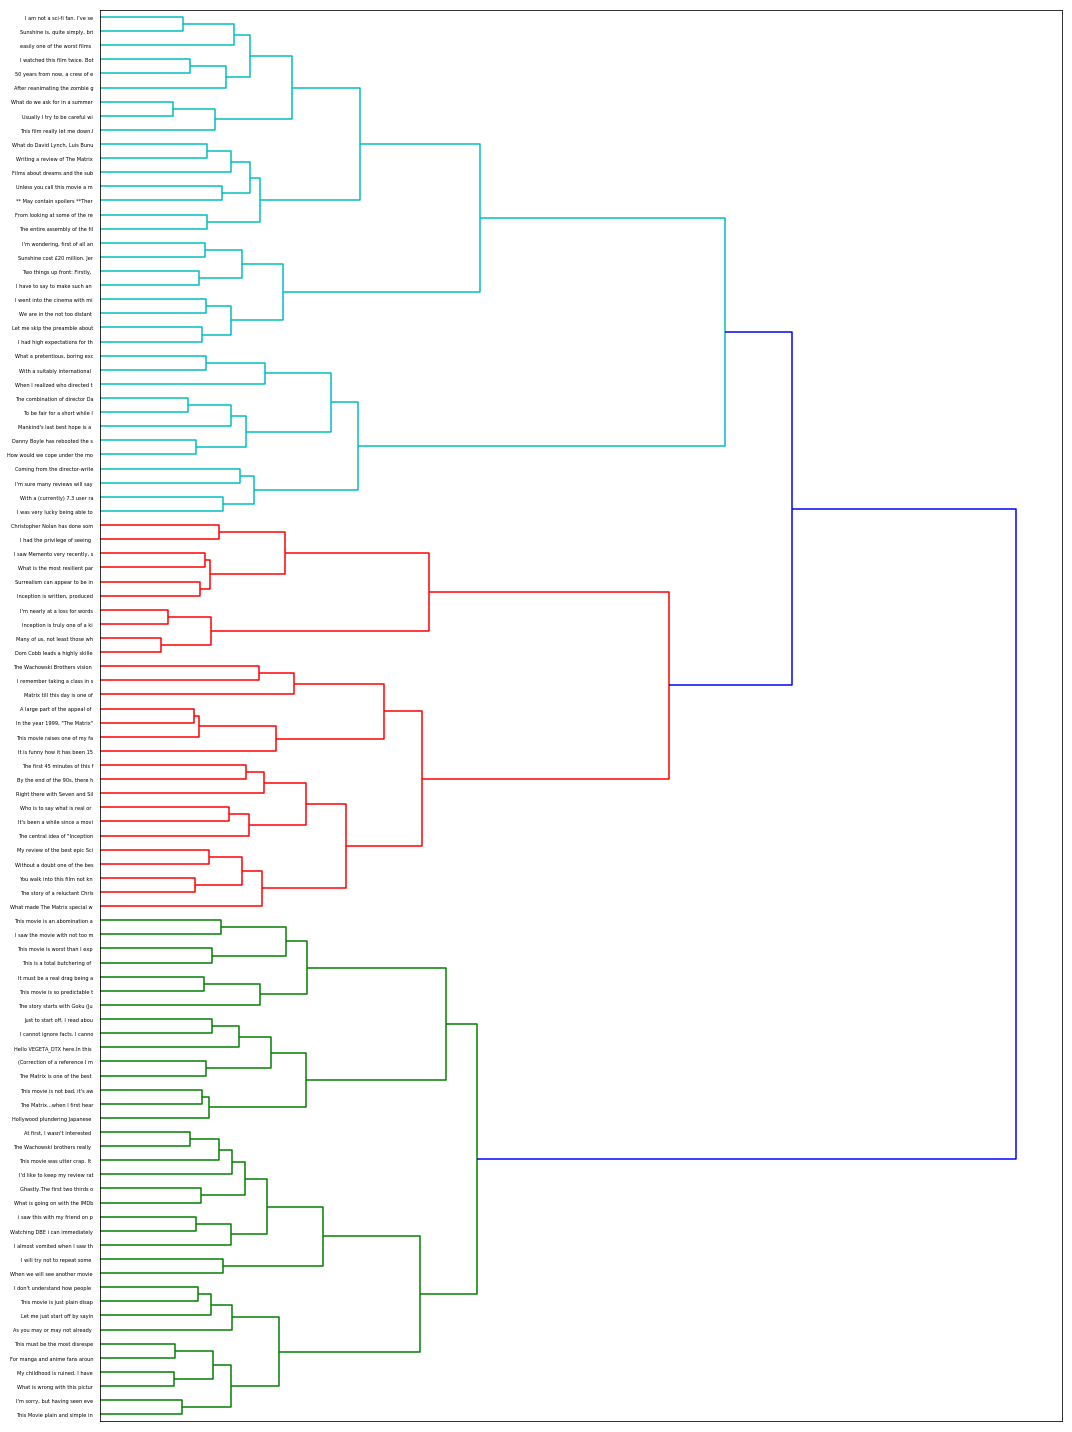

In [42]:
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#plt.savefig('ward_clusters.png') #save figure as ward_clusters